# 3. Model Training and Evaluation with Multiple Models

In [1]:
## 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, average_precision_score, auc, roc_curve,
    recall_score, balanced_accuracy_score, precision_score, f1_score,log_loss,make_scorer
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import joblib
import warnings
import xgboost as xgb
import multiprocessing
import concurrent.futures
import time

import kagglehub
import os
import shutil

In [2]:
# Check if we need to change working directory
current_dir = os.getcwd()
target_dir = os.path.dirname(current_dir)  # Get parent directory

if current_dir.endswith('notebooks'):  # Only change if we're in notebooks directory
    os.chdir('..')
    print(f"Changed working directory from {current_dir} to {os.getcwd()}")
else:
    print(f"Working directory already set to {current_dir}")

os.makedirs('data', exist_ok=True)  
os.makedirs('models', exist_ok=True) 

Changed working directory from c:\Work\GIT\Fraud-Detection-in-Job-Postings-A-Comprehensive-ML-Pipeline-Tutorial\notebooks to c:\Work\GIT\Fraud-Detection-in-Job-Postings-A-Comprehensive-ML-Pipeline-Tutorial


### Data Preparation and Oversampling with SMOTE

#### Purpose:
- Prepares features and target for training
- Balances the training data using SMOTE (Synthetic Minority Over-sampling Technique)
- Saves the data splits for future use

#### Operations:
1. **Separate Features and Target**:
   - Drops the target column (`fraudulent`) and any columns containing 'cleaned' from the feature set.
   - Separates the target variable `fraudulent`.

2. **Split Data with Stratification**:
   - Splits the data into training and test sets with stratification to maintain the class distribution.

3. **Display Original Class Distribution**:
   - Prints the class distribution of the training set before applying SMOTE.

4. **Determine Sampling Strategy**:
   - Calculates the sampling strategy based on the oversampling ratio.
   - The minority class is over-sampled by generating synthetic examples along the line segments joining the k nearest neighbors of each minority class sample.

5. **Apply SMOTE with Stratification**:
   - Uses SMOTE to balance the training data with the specified oversampling ratio.
   - SMOTE generates synthetic samples by taking the difference between a feature vector and its nearest neighbor, multiplying this difference by a random number between 0 and 1, and adding it to the feature vector. This selects a random point along the line segment between two specific features.
   - The implementation uses five nearest neighbors by default (`k_neighbors=5`).

6. **Create Class Distribution Tables**:
   - Creates tables showing the class distributions and their ratios for the original, balanced, and test sets.

7. **Save Data Splits**:
    - Saves the balanced training set, original training set, and test set to pickle files.

#### Why It's Important:
- **Balances the training data**: Ensures that the model is not biased towards the majority class by generating synthetic samples for the minority class.
- **Maintains class distribution in test set**: Stratified splitting ensures that the test set maintains the same class distribution as the original dataset.
- **Prepares data for modeling**: Saves the processed data splits for future use in model training and evaluation.


In [3]:
## 2. Load and Prepare Data
def prepare_and_save_data(df, oversampling_ratio=5.0,test_size=0.2):
    """Prepare features and target for training, and save the splits"""
    print("Preparing data splits...")
    
    # Separate features and target
    X = df.drop(['fraudulent'] + [col for col in df.columns if 'cleaned' in col], axis=1)
    y = df['fraudulent']
    
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y,shuffle=True
    )
    
    # Display original class distribution
    original_class_distribution = pd.Series(y_train).value_counts()
    
    # Determine the sampling strategy based on the oversampling ratio
    minority_class_count = original_class_distribution.min()
    sampling_strategy = {original_class_distribution.idxmin(): int(minority_class_count * oversampling_ratio)}
    
    # Apply SMOTE with stratification
    print(f"\nApplying SMOTE to balance training data with a ratio of {oversampling_ratio}...")
    smote = SMOTE(
    random_state=42, 
    sampling_strategy=sampling_strategy,
    k_neighbors=4  # Adaptive k_neighbors
    
)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
       
    # Convert to pandas
    X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train.columns)
    y_train_balanced = pd.Series(y_train_balanced)
    
    # Display balanced class distribution
    balanced_class_distribution = pd.Series(y_train_balanced).value_counts()
    
    # Display test target distribution
    test_class_distribution = pd.Series(y_test).value_counts()
    
    # Create a table with class distributions
    class_distribution_table = pd.DataFrame({
        'Total': original_class_distribution + test_class_distribution,
        'Target': original_class_distribution,
        'Target_Balanced': balanced_class_distribution,
        'Test': test_class_distribution
    })
    
    # Create a table with class distribution ratios
    class_distribution_ratios = class_distribution_table.div(class_distribution_table.sum(axis=0), axis=1)
    
    print("\nClass distribution table:")
    print(class_distribution_table)
    
    print("\nClass distribution ratios:")
    print(class_distribution_ratios)
    
    # Save the splits
    print("\nSaving data splits...")
    pd.to_pickle(X_train_balanced, 'data/X_train_balanced.pkl')
    pd.to_pickle(X_train, 'data/X_train.pkl')
    pd.to_pickle(X_test, 'data/X_test.pkl')
    pd.to_pickle(y_train_balanced, 'data/y_train_balanced.pkl')
    pd.to_pickle(y_train, 'data/y_train.pkl')
    pd.to_pickle(y_test, 'data/y_test.pkl')
    
    print("Data splits saved successfully!")
    
    return X_train_balanced, X_test, y_train_balanced, y_test

# Example usage
#df = pd.read_pickle('data/engineered_features.pkl')
#X_train_balanced, X_test, y_train_balanced, y_test = prepare_and_save_data(df, oversampling_ratio=5.0,test_size=0.2)

In [4]:
#https://medium.com/dvt-engineering/hyper-parameter-tuning-for-scikit-learn-ml-models-860747bc3d72

### 2.Model Parameter Grids

### Function: `optimize_all_models`

This function optimizes multiple machine learning models using HalvingGridSearchCV  with a specified optimization goal. It returns the best models and their scores.

#### Purpose:
- To find the best hyperparameters for different models using a systematic search.
- To optimize models based on a specified performance metric.

#### Parameters:
- **X_train**: Training feature set.
- **y_train**: Training target set.
- **optimization_goal**: The metric to optimize for. Options include 'average_precision', 'recall', 'roc_auc', 'balanced_accuracy', 'precision', 'f1_weighted'.
- **factor**: Reduction factor between iterations in HalvingGridSearchCV. Higher values mean fewer iterations.

#### Operations:
1. **Define Scoring Metric**:
   - Maps the optimization_goal to the corresponding scoring metric used by scikit-learn.
   

2. **Define Models and Parameter Grids**:
   - Specifies the models to be optimized and their corresponding parameter grids:
     - **XGBoost**: Uses XGBClassifier and parameters from get_xgboost_params.
     - **Neural Network**: Uses MLPClassifier and parameters from get_neural_net_params.
     - **CatBoost**: Uses CatBoostClassifier and parameters from get_catboost_params.

4. **Optimize Each Model**:
   - Iterates over each model and its parameter grid.
   - Prints the name of the model being optimized.
   - Uses HalvingGridSearchCV  to perform hyperparameter optimization:
     - **estimator**: The model to optimize.
     - **param_grid**: Grid of parameters to search through.
     - **scoring**: Metric used to evaluate model performance during optimization.
     - **refit**: Metric used to select the best model and refit on the full dataset.
     - **n_jobs**: Number of parallel jobs (-1 means using all processors).
     - **factor**: Reduction factor between iterations (higher means fewer iterations).
     - **cv**: Number of cross-validation folds.
     - **random_state**: Random seed for reproducibility.
   - **HalvingGridSearchCV**:
     - **Purpose**: Efficiently searches for the best hyperparameters by progressively reducing the number of candidates while increasing the number of resources (e.g., iterations, samples) allocated to each candidate.
     - **Process**: Starts with a large number of candidates and evaluates them with a small amount of resources. In each iteration, only the best candidates are selected for the next round, with increased resources. This continues until the specified number of iterations or candidates is reached.
   - Fits the model to the training data.
   - Stores the best model and its score in the optimized_models dictionary.
   - Prints the best parameters and score for each model.

5. **Return Optimized Models**:
   - Returns the dictionary of optimized models and their scores.

from sklearn.model_selection import RandomizedSearchCV, cross_validate, learning_curve
from sklearn.metrics import make_scorer, precision_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

def plot_learning_curves(estimator, X_train, y_train, X_test, y_test, cv=5):
    """Enhanced learning curves with test scores"""
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_train, y_train,
        cv=cv, n_jobs=-1,
        train_sizes=train_sizes,
        scoring=make_scorer(precision_score, zero_division=0)
    )
    
    # Get test scores
    test_scores = []
    for size in train_sizes:
        n_samples = int(size * len(X_train))
        estimator.fit(X_train[:n_samples], y_train[:n_samples])
        test_scores.append(precision_score(y_test, estimator.predict(X_test), zero_division=0))
    
    plt.figure(figsize=(12, 5))
    
    # Learning curves
    plt.subplot(1, 2, 1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Cross-validation')
    plt.plot(train_sizes, test_scores, 'o-', label='Test')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    
    # Overfitting gap
    plt.subplot(1, 2, 2)
    plt.plot(train_sizes, np.mean(train_scores, axis=1) - np.mean(val_scores, axis=1), 
             'r-', label='Train-Val Gap')
    plt.plot(train_sizes, np.mean(train_scores, axis=1) - test_scores,
             'b-', label='Train-Test Gap')
    plt.xlabel('Training Examples')
    plt.ylabel('Score Gap')
    plt.title('Overfitting Gap')
    plt.legend(loc='best')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return np.mean(train_scores[-1]), np.mean(val_scores[-1]), test_scores[-1]

def optimize_models_improved(X_train, y_train, X_test, y_test,
                           max_overfitting=0.1,
                           min_score=0.7):
    """Improved model optimization with comprehensive metrics and stronger regularization"""
    best_models = {}
    
    for name, (model, params) in [
        ('xgboost', (XGBClassifier(
            random_state=42,
            reg_alpha=0.3,           # Increased L1 regularization
            reg_lambda=1.5,          # Increased L2 regularization
            subsample=0.8,           # Added subsampling
            colsample_bytree=0.8     # Added column sampling
        ), {
            'max_depth': randint(2, 5),              # Reduced max depth range
            'learning_rate': uniform(0.01, 0.09),    # Reduced learning rate range
            'n_estimators': randint(100, 300)        # Adjusted estimators range
        })),
        ('neural_net', (MLPClassifier(
            random_state=42,
            alpha=0.1,               # Increased L2 regularization
            early_stopping=True,     # Added early stopping
            validation_fraction=0.2,  # Increased validation fraction
            n_iter_no_change=10      # Added patience for early stopping
        ), {
            'hidden_layer_sizes': [(x,) for x in randint(30, 151).rvs(10)],  # Reduced network size
            'alpha': uniform(0.05, 0.15)             # Increased alpha range
        }))
    ]:
        print(f"\nOptimizing {name}...")
        
        search = RandomizedSearchCV(
            model, params, n_iter=20, cv=3,
            scoring=make_scorer(precision_score, zero_division=0),
            n_jobs=-1, random_state=42
        )
        
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        
        # Plot comprehensive learning curves
        train_score, val_score, test_score = plot_learning_curves(
            best_model, X_train, y_train, X_test, y_test
        )
        
        overfitting_gap = train_score - test_score
        print(f"Final Scores - Train: {train_score:.3f}, Val: {val_score:.3f}, Test: {test_score:.3f}")
        print(f"Overfitting Gap: {overfitting_gap:.3f}")
        
        if overfitting_gap <= max_overfitting and test_score >= min_score:
            best_models[name] = (best_model, test_score)
        else:
            print(f"Model {name} rejected due to overfitting or poor performance")
            
    return best_models

df = pd.read_pickle('data/engineered_features.pkl')
X_train_balanced, X_test, y_train_balanced, y_test = prepare_and_save_data(df, oversampling_ratio=2.0,test_size=0.25)

optimized_models = optimize_models_improved(
    X_train_balanced, 
    y_train_balanced,
    X_test,
    y_test,
    max_overfitting=0.15,
    min_score=0.7
)

In [5]:
from sklearn.model_selection import RandomizedSearchCV, cross_validate, learning_curve
from sklearn.metrics import make_scorer, precision_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

def plot_learning_curves(estimator, X_train, y_train, X_test, y_test, cv=5):
    """Enhanced learning curves with test scores"""
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_train, y_train,
        cv=cv, n_jobs=-1,
        train_sizes=train_sizes,
        scoring=make_scorer(precision_score, zero_division=0)
    )
    
    # Get test scores
    test_scores = []
    for size in train_sizes:
        n_samples = int(size * len(X_train))
        estimator.fit(X_train[:n_samples], y_train[:n_samples])
        test_scores.append(precision_score(y_test, estimator.predict(X_test), zero_division=0))
    
    plt.figure(figsize=(12, 5))
    
    # Learning curves
    plt.subplot(1, 2, 1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Cross-validation')
    plt.plot(train_sizes, test_scores, 'o-', label='Test')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    
    # Overfitting gap
    plt.subplot(1, 2, 2)
    plt.plot(train_sizes, np.mean(train_scores, axis=1) - np.mean(val_scores, axis=1), 
             'r-', label='Train-Val Gap')
    plt.plot(train_sizes, np.mean(train_scores, axis=1) - test_scores,
             'b-', label='Train-Test Gap')
    plt.xlabel('Training Examples')
    plt.ylabel('Score Gap')
    plt.title('Overfitting Gap')
    plt.legend(loc='best')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return np.mean(train_scores[-1]), np.mean(val_scores[-1]), test_scores[-1]

def optimize_models_improved(X_train, y_train, X_test, y_test,
                           max_overfitting=0.1,
                           min_score=0.7,
                           optimization_metric='precision',
                           n_iter=20,
                           cv=3):
    """
    Improved model optimization with comprehensive metrics and stronger regularization
    
    Parameters:
    -----------
    X_train, y_train : Training data
    X_test, y_test : Test data
    max_overfitting : float, maximum acceptable difference between train and test scores
    min_score : float, minimum acceptable test score
    optimization_metric : str, metric to optimize ('precision', 'recall', 'f1', etc.)
    n_iter : int, number of random iterations for search
    cv : int, number of cross-validation folds
    """
    best_models = {}
    

    # Define models and their parameters
    models_config = {
        'xgboost': (XGBClassifier(
            random_state=42,
            reg_alpha=0.3,           # Increased L1 regularization
            reg_lambda=1.5,          # Increased L2 regularization
            subsample=0.8,           # Added subsampling
            colsample_bytree=0.8     # Added column sampling   
        ), {
            'max_depth': randint(2, 5),              # Reduced max depth range
            'learning_rate': uniform(0.01, 0.09),    # Reduced learning rate range
            'n_estimators': randint(100, 300)        # Adjusted estimators range      
        }),
        
        'neural_net': (MLPClassifier(
            random_state=42,
            alpha=0.1,               # Increased L2 regularization
            early_stopping=True,     # Added early stopping
            validation_fraction=0.2,  # Increased validation fraction
            n_iter_no_change=10      # Added patience for early stopping  
        ), {
            'hidden_layer_sizes': [(x,) for x in randint(30, 151).rvs(10)],  
            'alpha': uniform(0.05, 0.15)             
        })
    }
    
    # Select scoring metric
    scoring = make_scorer(
        {
            'precision': precision_score,
            'recall': recall_score,
            'f1': f1_score,
            'balanced_accuracy': balanced_accuracy_score
        }.get(optimization_metric, precision_score),
        zero_division=0
    )
    
    for name, (model, params) in models_config.items():
        print(f"\nOptimizing {name}...")
        
        try:
            search = RandomizedSearchCV(
                model, params, 
                n_iter=n_iter, 
                cv=cv,
                scoring=scoring,
                n_jobs=-1, 
                random_state=42
            )
            
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            
            # Plot comprehensive learning curves
            train_score, val_score, test_score = plot_learning_curves(
                best_model, X_train, y_train, X_test, y_test
            )
            
            overfitting_gap = train_score - test_score
            print(f"Final Scores - Train: {train_score:.3f}, Val: {val_score:.3f}, Test: {test_score:.3f}")
            print(f"Overfitting Gap: {overfitting_gap:.3f}")
            
            if overfitting_gap <= max_overfitting and test_score >= min_score:
                best_models[name] = (best_model, test_score)
                print(f"Model accepted - Test score: {test_score:.3f}")
            else:
                print(f"Model {name} rejected - Overfitting: {overfitting_gap:.3f}, Test score: {test_score:.3f}")
                
        except Exception as e:
            print(f"Error optimizing {name}: {str(e)}")
            continue
            
    return best_models
df = pd.read_pickle('data/engineered_features.pkl')


# Example usage:
#X_train_balanced, X_test, y_train_balanced, y_test = prepare_and_save_data(df, oversampling_ratio=2.0,test_size=0.25)
#optimized_models = optimize_models_improved(
#    X_train_balanced, 
#    y_train_balanced,
#    X_test,
#    y_test,
#    max_overfitting=0.15,
#    min_score=0.7,
#    optimization_metric='precision',
#    n_iter=20,
#    cv=3
#)

# Example usage
if __name__ == "__main__":
    # Assuming X_train_balanced and y_train_balanced are already defined
    # Optimize models
    optimization_goal = 'precision'
    optimized_models = optimize_all_models(X_train_balanced, y_train_balanced, optimization_goal=optimization_goal)
    
    # Create and train stacking model
    stacking_model = create_stacking_model(optimized_models, X_train_balanced, y_train_balanced)
    
    # Evaluate stacking model
    scores = cross_val_score(
        stacking_model, X_train_balanced, y_train_balanced, cv=2, scoring=optimization_goal
    )
    print("Stacking model evaluated successfully.")
    print(f"Stacking Model Precision Scores: {scores}")
    print(f"Mean Precision Score: {scores.mean():.4f}")

#### Function: `evaluate_model`

This function evaluates the performance of a predictive model using various metrics and visualizations.

- **Purpose**: To evaluate the performance of a predictive model.
- **Parameters**:
  - `model`: The predictive model to evaluate.
  - `X_test`: Test feature set.
  - `y_test`: Test target set.
  - `model_name`: Name of the model (default is "Model").
- **Operations**:
  1. Predicts the labels and probabilities for the test set.
  2. Prints performance metrics including ROC AUC, Recall, Precision, and Balanced Accuracy.
  3. Calculates and prints the precision-recall curve, PR AUC, and Average Precision.
  4. Prints the classification report.
  5. Calculates and prints the lift scores by decile.
  6. Creates visualizations including a confusion matrix heatmap, ROC curve, precision-recall curve, and lift chart.
  7. If the model has feature importances, calculates and plots feature importance stability.
  8. Plots the prediction probability distributions for the training and test sets.

#### Additional Functionality: Combined Model Evaluation

To evaluate and compare the performance of multiple models, we can extend the `evaluate_model` function to include additional tables and graphs that combine all models.





In [6]:
def plot_learning_curves(estimator, X_train, y_train, X_test, y_test, cv=5):
    """Enhanced learning curves with test scores"""
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_train, y_train,
        cv=cv, n_jobs=-1,
        train_sizes=train_sizes,
        scoring=make_scorer(precision_score, zero_division=0)
    )
    
    # Get test scores
    test_scores = []
    for size in train_sizes:
        n_samples = int(size * len(X_train))
        estimator.fit(X_train[:n_samples], y_train[:n_samples])
        test_scores.append(precision_score(y_test, estimator.predict(X_test), zero_division=0))
    
    plt.figure(figsize=(12, 5))
    
    # Learning curves
    plt.subplot(1, 2, 1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Cross-validation')
    plt.plot(train_sizes, test_scores, 'o-', label='Test')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    
    # Overfitting gap
    plt.subplot(1, 2, 2)
    plt.plot(train_sizes, np.mean(train_scores, axis=1) - np.mean(val_scores, axis=1), 
             'r-', label='Train-Val Gap')
    plt.plot(train_sizes, np.mean(train_scores, axis=1) - test_scores,
             'b-', label='Train-Test Gap')
    plt.xlabel('Training Examples')
    plt.ylabel('Score Gap')
    plt.title('Overfitting Gap')
    plt.legend(loc='best')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return np.mean(train_scores[-1]), np.mean(val_scores[-1]), test_scores[-1]

def calculate_lift(y_true, y_pred_proba, bins=10):
    """Calculate lift score"""
    df = pd.DataFrame({'true': y_true, 'prob': y_pred_proba})
    df = df.sort_values('prob', ascending=False)
    
    total_positive = df['true'].sum()
    records_per_bin = len(df) // bins
    
    lifts = []
    for i in range(bins):
        bin_data = df.iloc[i*records_per_bin:(i+1)*records_per_bin]
        positives_in_bin = bin_data['true'].sum()
        
        expected_positives = total_positive * (records_per_bin / len(df))
        lift = positives_in_bin / expected_positives if expected_positives > 0 else 0
        lifts.append(lift)
    
    return lifts

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Evaluate individual model performance with detailed metrics and visualizations"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Print metrics
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Calculate and print lift scores
    lifts = calculate_lift(y_test, y_pred_proba)
    print("\nLift Scores by Decile:")
    for i, lift in enumerate(lifts, 1):
        print(f"Decile {i}: {lift:.2f}")
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'Confusion Matrix - {model_name}')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_title(f'ROC Curve (AUC = {metrics["ROC AUC"]:.4f})')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    
    # Precision-Recall Curve
    ax3.plot(recall, precision)
    ax3.set_title(f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    
    # Lift Chart
    ax4.plot(range(1, len(lifts) + 1), lifts, marker='o')
    ax4.axhline(y=1, color='r', linestyle='--')
    ax4.set_title('Lift Chart by Decile')
    ax4.set_xlabel('Decile')
    ax4.set_ylabel('Lift')
    
    plt.tight_layout()
    plt.show()
    
    return metrics, pr_auc, avg_precision

def evaluate_multiple_models(optimized_models, X_test, y_test):
    """Evaluate and compare multiple models"""
    results = []
    
    # Evaluate each model
    for model_name, (model, _) in optimized_models.items():
        try:
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            # Calculate metrics
            metrics = {
                'Model': model_name,
                'ROC AUC': roc_auc_score(y_test, y_pred_proba),
                'Recall': recall_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
                'F1 Score': f1_score(y_test, y_pred)
            }
            
            # Calculate PR AUC
            precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
            metrics['PR AUC'] = auc(recall_vals, precision_vals)
            metrics['Average Precision'] = average_precision_score(y_test, y_pred_proba)
            
            results.append(metrics)
            
            # Print individual model evaluation
            print(f"\nDetailed evaluation for {model_name}:")
            evaluate_model(model, X_test, y_test, model_name)
            
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            continue
    
    # Create and display results DataFrame
    results_df = pd.DataFrame(results)
    print("\nModel Performance Comparison:")
    print(results_df.round(4))
    
    # Plot performance comparison
    metrics_to_plot = ['ROC AUC', 'Precision', 'Recall', 'F1 Score', 'PR AUC']
    
    plt.figure(figsize=(15, 8))
    results_df[['Model'] + metrics_to_plot].set_index('Model').plot(kind='bar', ax=plt.gca())
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot ROC curves comparison
    plt.figure(figsize=(10, 8))
    for model_name, (model, _) in optimized_models.items():
        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
        except Exception as e:
            print(f"Error plotting ROC curve for {model_name}: {str(e)}")
            continue
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Plot PR curves comparison
    plt.figure(figsize=(10, 8))
    for model_name, (model, _) in optimized_models.items():
        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            avg_precision = average_precision_score(y_test, y_pred_proba)
            plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.3f})')
        except Exception as e:
            print(f"Error plotting PR curve for {model_name}: {str(e)}")
            continue
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves Comparison')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()
    
    return results_df

def check_imbalanced_overfitting(model, X_train, X_test, y_train, y_test, model_name):
    """Comprehensive overfitting analysis for imbalanced datasets"""
    print(f"\nAnalyzing {model_name} for overfitting...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Get predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'ROC AUC': {
            'train': roc_auc_score(y_train, train_proba),
            'test': roc_auc_score(y_test, test_proba)
        },
        'Average Precision': {
            'train': average_precision_score(y_train, train_proba),
            'test': average_precision_score(y_test, test_proba)
        },
        'F1 Score': {
            'train': f1_score(y_train, train_pred),
            'test': f1_score(y_test, test_pred)
        },
        'Recall': {
            'train': recall_score(y_train, train_pred),
            'test': recall_score(y_test, test_pred)
        },
        'Precision': {
            'train': precision_score(y_train, train_pred),
            'test': precision_score(y_test, test_pred)
        }
    }
    
    # Calculate gaps
    gaps = {metric: scores['train'] - scores['test'] 
            for metric, scores in metrics.items()}
    
    # Print results
    print("\nMetrics Analysis:")
    for metric, scores in metrics.items():
        print(f"\n{metric}:")
        print(f"Training Score: {scores['train']:.4f}")
        print(f"Test Score: {scores['test']:.4f}")
        print(f"Gap: {gaps[metric]:.4f}")
        
        if metric in ['ROC AUC', 'Average Precision']:
            if gaps[metric] > 0.1:
                print("Status: High overfitting")
            elif gaps[metric] > 0.05:
                print("Status: Moderate overfitting")
            else:
                print("Status: Good fit")
    
    # Plot metrics comparison
    plt.figure(figsize=(15, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, [scores['train'] for scores in metrics.values()],
            width, label='Training', color='skyblue')
    plt.bar(x + width/2, [scores['test'] for scores in metrics.values()],
            width, label='Test', color='lightcoral')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(f'Training vs Test Metrics - {model_name}')
    plt.xticks(x, metrics.keys(), rotation=45)
    plt.legend()
    
    for i, (metric, gap) in enumerate(gaps.items()):
        plt.text(i, min(metrics[metric].values()),
                f'Gap: {gap:.3f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return metrics, gaps

Preparing data splits...

Applying SMOTE to balance training data with a ratio of 2.0...

Class distribution table:
   Total  Target  Target_Balanced  Test
0  17014   12760            12760  4254
1    866     650             1300   216

Class distribution ratios:
      Total    Target  Target_Balanced      Test
0  0.951566  0.951529         0.907539  0.951678
1  0.048434  0.048471         0.092461  0.048322

Saving data splits...
Data splits saved successfully!

Optimizing xgboost...


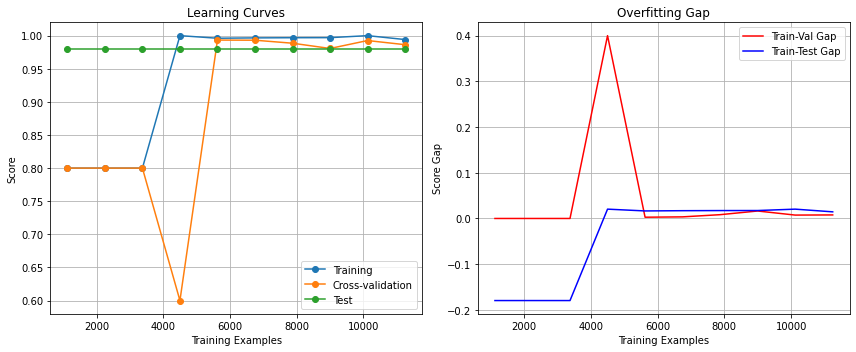

Final Scores - Train: 0.994, Val: 0.986, Test: 0.980
Overfitting Gap: 0.014
Model accepted - Test score: 0.980

Optimizing neural_net...


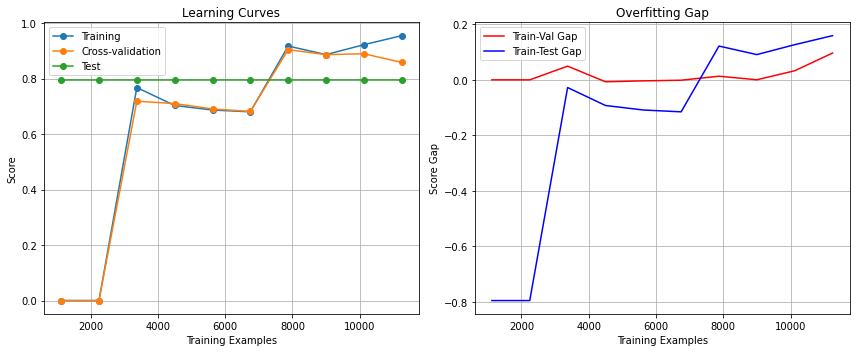

Final Scores - Train: 0.955, Val: 0.858, Test: 0.796
Overfitting Gap: 0.159
Model neural_net rejected - Overfitting: 0.159, Test score: 0.796

Detailed evaluation for xgboost:

xgboost Performance:
ROC AUC: 0.9343
Recall: 0.2222
Precision: 0.9796
Balanced Accuracy: 0.6110
F1 Score: 0.3623
PR AUC: 0.6080
Average Precision: 0.6090

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4254
           1       0.98      0.22      0.36       216

    accuracy                           0.96      4470
   macro avg       0.97      0.61      0.67      4470
weighted avg       0.96      0.96      0.95      4470


Lift Scores by Decile:
Decile 1: 6.90
Decile 2: 1.81
Decile 3: 0.65
Decile 4: 0.42
Decile 5: 0.14
Decile 6: 0.05
Decile 7: 0.05
Decile 8: 0.00
Decile 9: 0.00
Decile 10: 0.00


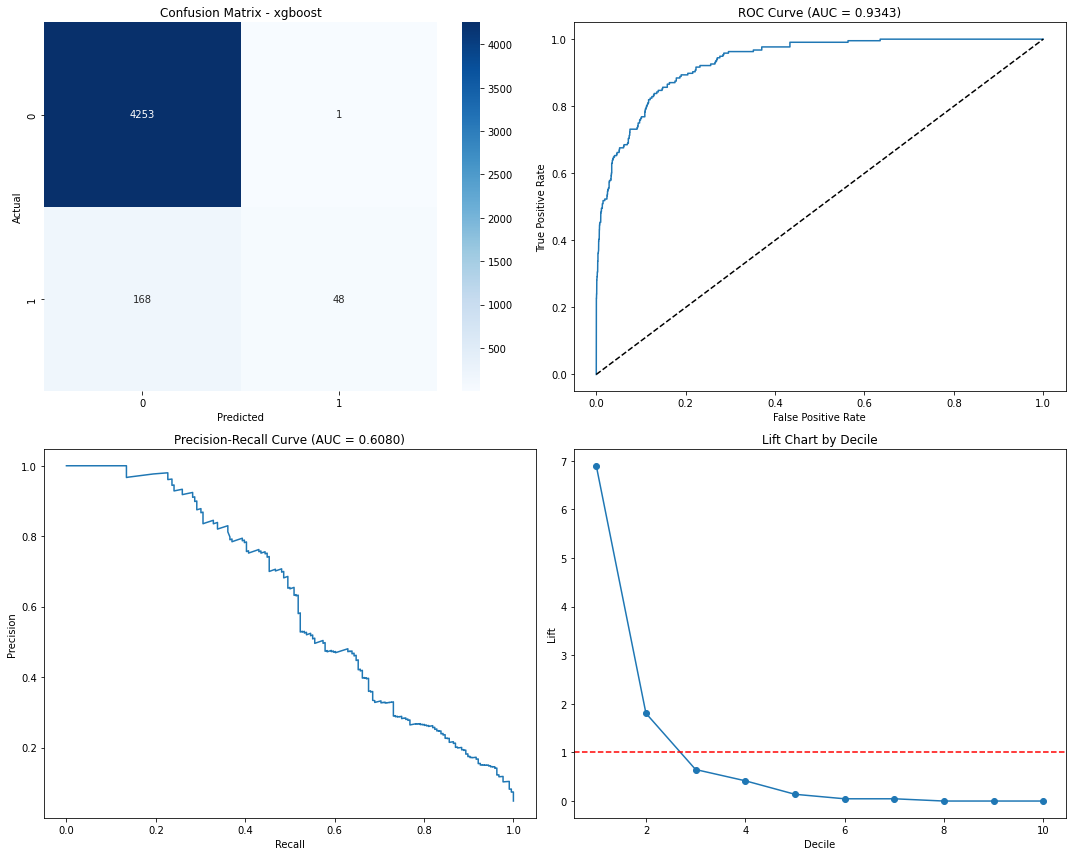


Model Performance Comparison:
     Model  ROC AUC  Recall  Precision  Balanced Accuracy  F1 Score  PR AUC  \
0  xgboost   0.9343  0.2222     0.9796              0.611    0.3623   0.608   

   Average Precision  
0              0.609  


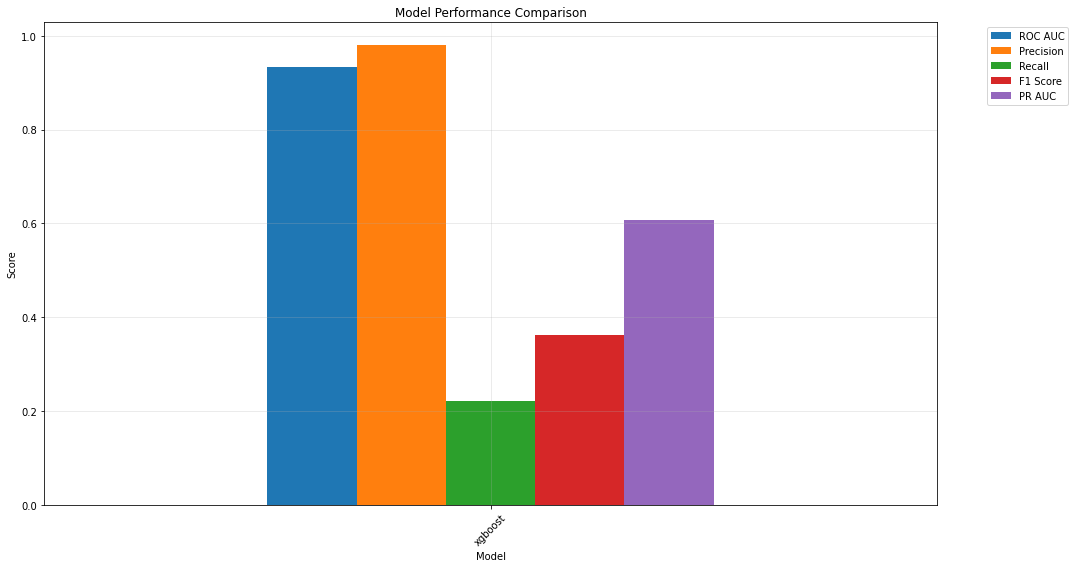

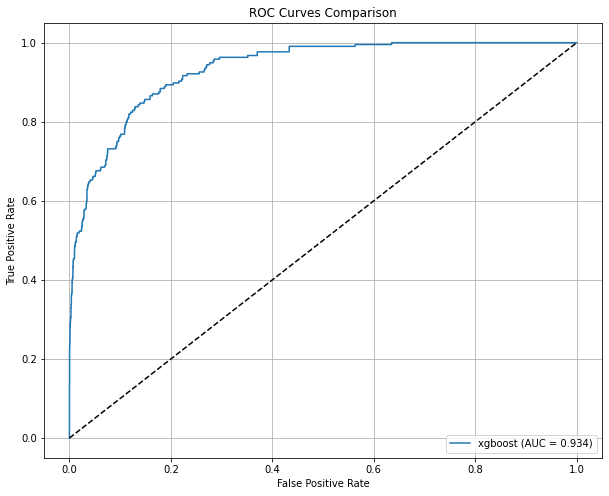

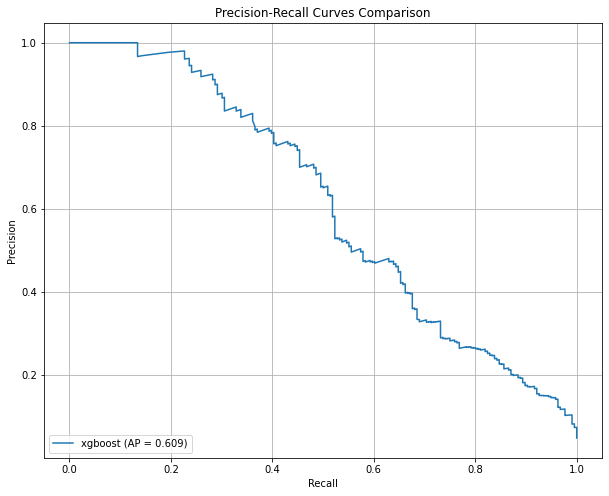


Best model by different metrics:
Best ROC AUC: xgboost (0.9343)
Best Precision: xgboost (0.9796)
Best Recall: xgboost (0.2222)
Best F1 Score: xgboost (0.3623)
Best PR AUC: xgboost (0.6080)

Analyzing xgboost for overfitting...

Metrics Analysis:

ROC AUC:
Training Score: 0.9502
Test Score: 0.9343
Gap: 0.0160
Status: Good fit

Average Precision:
Training Score: 0.7558
Test Score: 0.6090
Gap: 0.1468
Status: High overfitting

F1 Score:
Training Score: 0.3694
Test Score: 0.3623
Gap: 0.0072

Recall:
Training Score: 0.2269
Test Score: 0.2222
Gap: 0.0047

Precision:
Training Score: 0.9933
Test Score: 0.9796
Gap: 0.0137


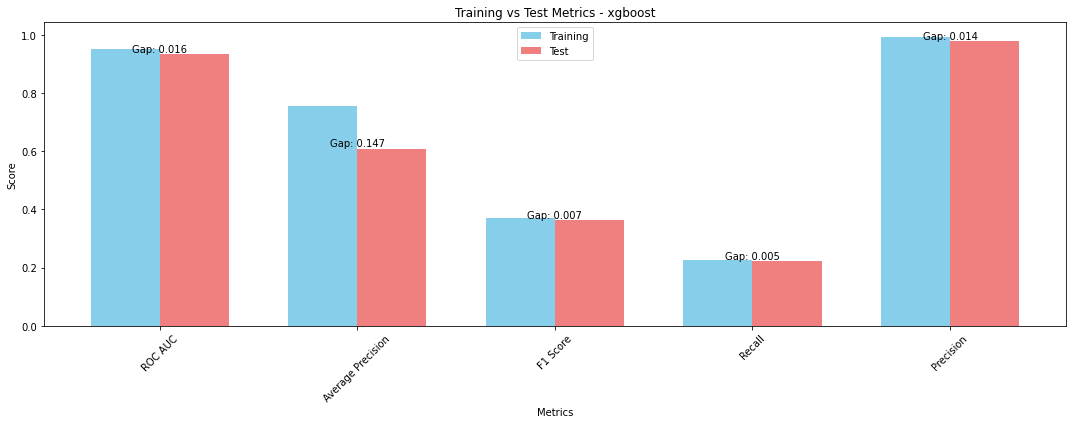

TypeError: save_models() missing 1 required positional argument: 'stacking_model'

In [7]:
def save_models(optimized_models, stacking_model):
    """Save all trained models"""
    print("\nSaving models...")
    import os
    os.makedirs('models', exist_ok=True)
    
    
    for name, (model, _) in optimized_models.items():
        joblib.dump(model, f'models/{name}_model.joblib')
    print("Models saved successfully!")


df = pd.read_pickle('data/engineered_features.pkl')
X_train, X_test, y_train, y_test = prepare_and_save_data(df, oversampling_ratio=2.0,test_size=0.25)

if __name__ == "__main__":   

    # Optimize models
    # f1_weighted or  precision
    optimization_goal = 'precision'
    
    optimized_models = optimize_models_improved(
        X_train, 
        y_train,
        X_test,
        y_test,
        max_overfitting=0.15,
        min_score=0.7,
        optimization_metric='precision',
        n_iter=20,
        cv=3
    )

    results_df = evaluate_multiple_models(optimized_models, X_test, y_test)
    
    print("\nBest model by different metrics:")
    for metric in ['ROC AUC', 'Precision', 'Recall', 'F1 Score', 'PR AUC']:
        best_model = results_df.loc[results_df[metric].idxmax()]
        print(f"Best {metric}: {best_model['Model']} ({best_model[metric]:.4f})")
    
    # Check for overfitting in each model
    for model_name, (model, _) in optimized_models.items():
        metrics, gaps = check_imbalanced_overfitting(
            model, X_train, X_test, y_train, y_test, model_name
        )
    save_models(optimized_models)    